In [16]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx

import dem_functions as df
import bikeability_functions as bf
import yan_helper_functions as yhf

In [2]:
def calc_metrics(G, dem_SF, total_length_added: int, num_cc: int) -> pd.DataFrame:
    betas = np.linspace(0.01, 10, 200)
    curves_SF = bf.compute_bikeability_curves(G, G.nodes(), dest="all")
    user_dict_SF = bf.network_wide_bikeability_curve(betas, curves_SF)

    keys = [
        "frac_pop_nonwhite",
        "frac_below_poverty",
        "median_hh_income",
        "frac_no_car",
    ]
    quant_of_int = df.all_quants(keys, dem_SF)
    nonwhite_low, nonwhite_high = yhf.quint_curves(G, quant_of_int, "frac_pop_nonwhite")
    poverty_low, poverty_high = yhf.quint_curves(G, quant_of_int, "frac_below_poverty")
    income_low, income_high = yhf.quint_curves(G, quant_of_int, "median_hh_income")
    carless_low, carless_high = yhf.quint_curves(G, quant_of_int, "frac_no_car")

    new_row = {
        "length_added_bikelanes": total_length_added,
        "number_cc": num_cc,
        "overall_score": bf.calc_elbow(user_dict_SF),
        "nonwhite_high": bf.calc_elbow(nonwhite_high),
        "nonwhite_low": bf.calc_elbow(nonwhite_low),
        "poverty_high": bf.calc_elbow(poverty_high),
        "poverty_low": bf.calc_elbow(poverty_low),
        "income_high": bf.calc_elbow(income_high),
        "income_low": bf.calc_elbow(income_low),
        "carless_high": bf.calc_elbow(carless_high),
        "carless_low": bf.calc_elbow(carless_low),
    }

    return pd.DataFrame([new_row])

In [3]:
def large_to_close(G, G_bikelanes: nx.DiGraph) -> tuple[set, set]:
    """Returns tuple of sets of nodes in largest connected component and the
    closest connected component to the largest of the bike lane graph

    Args:
        G_bikelanes (nx.DiGraph): Graph of bike lanes

    Returns:
        tuple[set, set]: Tuple of sets of nodes in largest connected component and the
    closest connected component to the largest of the bike lane graph
    """

    ccs = sorted(nx.strongly_connected_components(G_bikelanes), key=len, reverse=True)

    # compute centroids of connected components
    cc_centroids = []

    for component in ccs:
        x_list, y_list = [], []

        for node in component:
            x_list.append(G.nodes[node]["x"])
            y_list.append(G.nodes[node]["y"])

        cc_centroids.append((np.mean(x_list), np.mean(y_list)))

    # find closest connected component to largest
    sqrd_dists = []

    for j in cc_centroids:
        sqrd_dists.append(
            (cc_centroids[0][0] - j[0]) ** 2 + (cc_centroids[0][1] - j[1]) ** 2
        )

    nodes_cc1 = ccs[0]  # largest connected component
    nodes_cc2 = ccs[
        np.argsort(sqrd_dists)[1]
    ]  # closest connected component to largest connected component

    return nodes_cc1, nodes_cc2

In [4]:
def large_to_second(G, G_bikelanes: nx.DiGraph) -> tuple[set, set]:
    """Return tuple of sets of largest connected component and second largest
    connected component of G_bikelanes.

    Args:
        G_bikelanes (nx.DiGraph): Graph of bike lanes.

    Returns:
        tuple[set, set]: Tuple of sets of largest connected component and second
        largest connected component
    """
    ccs = sorted(nx.strongly_connected_components(G_bikelanes), key=len, reverse=True)

    nodes_cc1 = ccs[0]  # largest connected component
    nodes_cc2 = ccs[1]  # second largest

    return nodes_cc1, nodes_cc2

In [5]:
def random_to_close(G, G_bikelanes: nx.DiGraph) -> tuple[set, set]:
    ccs = sorted(nx.strongly_connected_components(G_bikelanes), key=len, reverse=True)

    random_cc_index = np.random.choice(range(len(ccs)))

    component_centroids = []

    for component in ccs:
        x_list = []
        y_list = []

        for node in component:
            x_list.append(G.nodes[node]["x"])
            y_list.append(G.nodes[node]["y"])

        component_centroids.append((np.mean(x_list), np.mean(y_list)))

    sqrd_dists = []
    for j in component_centroids:
        sqrd_dists.append(
            (component_centroids[random_cc_index][0] - j[0]) ** 2
            + (component_centroids[random_cc_index][1] - j[1]) ** 2
        )

    nodes_cc1 = ccs[random_cc_index]  # random connected component
    nodes_cc2 = ccs[
        np.argsort(sqrd_dists)[1]
    ]  # closest connected component to random connected component

    return nodes_cc1, nodes_cc2

In [6]:
def closest_components(G, G_bikelanes: nx.DiGraph) -> tuple[set, set]:
    ccs = sorted(nx.strongly_connected_components(G_bikelanes), key=len, reverse=True)

    component_centroids = []

    for component in ccs:
        x_list = []
        y_list = []

        for node in component:
            x_list.append(G.nodes[node]["x"])
            y_list.append(G.nodes[node]["y"])

        component_centroids.append((np.mean(x_list), np.mean(y_list)))

    pair_dict = {}
    for j in range(len(component_centroids)):
        sqrd_dists = []
        for k in range(len(component_centroids)):
            sqrd_dists.append(
                (component_centroids[j][0] - component_centroids[k][0]) ** 2
                + (component_centroids[j][1] - component_centroids[k][1]) ** 2
            )

        pair_dict[sqrd_dists[np.argsort(sqrd_dists)[1]]] = (
            np.argsort(sqrd_dists)[1],
            j,
        )

    j, k = pair_dict[min(pair_dict.keys())]

    nodes_cc1 = ccs[j]  # closest component 1
    nodes_cc2 = ccs[k]  # closest component 2
    return nodes_cc1, nodes_cc2

In [10]:
def gen_data(alg) -> pd.DataFrame:

    len_constr_bike_lanes = 0

    G_SF, dem_SF = yhf.load_sf_data()

    dataframe = pd.DataFrame(
        columns=[
            "length_added_bikelanes",
            "number_cc",
            "overall_score",
            "nonwhite_high",
            "nonwhite_low",
            "poverty_high",
            "poverty_low",
            "income_high",
            "income_low",
            "carless_high",
            "carless_low",
        ]
    )

    # graph of all bikelanes
    G_bikelanes = nx.DiGraph()

    # graph of all potential bikelanes (i.e., roads and stroads)
    G_potential_bikelanes = nx.DiGraph()
    G_potential_bikelanes.add_nodes_from(G_SF.nodes(data=True))

    # create bikelane and potential bikelane networks
    for start_node, end_node, data in G_SF.edges(data=True):
        if not np.isnan(data["distance"][0]):
            G_bikelanes.add_edge(start_node, end_node, distance=data["distance"][0])

        G_potential_bikelanes.add_edge(
            start_node, end_node, distance=np.nanmin(data["distance"])
        )

    num_cc = nx.number_strongly_connected_components(G_bikelanes)

    dataframe = pd.concat(
        [dataframe, calc_metrics(G_SF, dem_SF, len_constr_bike_lanes, num_cc)]
    )

    while len_constr_bike_lanes < 1000 * 50:
        # print("Length of Constructed Bikelanes", len_constr_bike_lanes)

        # graph of all bikelanes
        G_bikelanes = nx.DiGraph()

        # graph of all potential bikelanes (i.e., roads and stroads)
        G_potential_bikelanes = nx.DiGraph()
        G_potential_bikelanes.add_nodes_from(G_SF.nodes(data=True))

        # create bikelane and potential bikelane networks
        for start_node, end_node, data in G_SF.edges(data=True):
            if not np.isnan(data["distance"][0]):
                G_bikelanes.add_edge(start_node, end_node, distance=data["distance"][0])

            G_potential_bikelanes.add_edge(
                start_node, end_node, distance=np.nanmin(data["distance"])
            )

        num_cc = nx.number_strongly_connected_components(G_bikelanes)

        if num_cc == 1:
            break

        nodes_cc1, nodes_cc2 = alg(G_SF, G_bikelanes)

        source_from_cc1 = None
        target_from_cc1 = None
        shortest_dist_from_cc1 = np.inf

        source_to_cc1 = None
        target_to_cc1 = None
        shortest_dist_to_cc1 = np.inf

        # compute shortest path from cc1 to cc2

        for j in nodes_cc1:

            for k in nodes_cc2:
                if nx.has_path(G_potential_bikelanes, source=j, target=k):
                    dist = nx.shortest_path_length(
                        G_potential_bikelanes, source=j, target=k, weight="distance"
                    )

                    if dist < shortest_dist_from_cc1:
                        source_from_cc1, target_from_cc1 = j, k

        # compute shortest path from cc2 to cc1
        for j in nodes_cc2:
            for k in nodes_cc1:
                if nx.has_path(G_potential_bikelanes, source=j, target=k):
                    dist = nx.shortest_path_length(
                        G_potential_bikelanes, source=j, target=k, weight="distance"
                    )

                    if dist < shortest_dist_to_cc1:
                        source_to_cc1, target_to_cc1 = j, k

        # construct new bike_lanes on G_SF and G_bikelanes
        short_path_from = nx.shortest_path(
            G_potential_bikelanes,
            source=source_from_cc1,
            target=target_from_cc1,
            weight="distance",
        )
        short_path_to = nx.shortest_path(
            G_potential_bikelanes,
            source=source_to_cc1,
            target=target_to_cc1,
            weight="distance",
        )

        for j in range(len(short_path_from) - 1):
            start_node = short_path_from[j]
            end_node = short_path_from[j + 1]

            len_new = G_potential_bikelanes[start_node][end_node]["distance"]
            len_old = G_SF[start_node][end_node][0]["distance"][0]

            if np.isnan(len_old) or len_new < len_old:
                G_SF[start_node][end_node][0]["distance"][0] = len_new
                len_constr_bike_lanes += len_new

        for j in range(len(short_path_to) - 1):
            start_node = short_path_to[j]
            end_node = short_path_to[j + 1]

            len_new = G_potential_bikelanes[start_node][end_node]["distance"]
            len_old = G_SF[start_node][end_node][0]["distance"][0]

            if np.isnan(len_old) or len_new < len_old:
                G_SF[start_node][end_node][0]["distance"][0] = len_new
                len_constr_bike_lanes += len_new

        prev_update_len = dataframe.iloc[-1]["length_added_bikelanes"]

        if len_constr_bike_lanes // 1000 >= prev_update_len // 1000 + 10:
            num_cc = nx.number_strongly_connected_components(G_bikelanes)
            dataframe = pd.concat(
                [dataframe, calc_metrics(G_SF, dem_SF, len_constr_bike_lanes, num_cc)]
            )

    # final calculations
    num_cc = nx.number_strongly_connected_components(G_bikelanes)
    dataframe = pd.concat(
        [dataframe, calc_metrics(G_SF, dem_SF, len_constr_bike_lanes, num_cc)]
    )

    return dataframe

In [ ]:
def gen_new_graph(alg):
    len_constr_bike_lanes = 0

    G_SF, dem_SF = yhf.load_sf_data()

    G_new = nx.DiGraph()
    G_new.add_nodes_from(G_SF.nodes(data=True))

    while len_constr_bike_lanes < 1000 * 50:
        # print("Length of Constructed Bikelanes", len_constr_bike_lanes)

        # graph of all bikelanes
        G_bikelanes = nx.DiGraph()

        # graph of all potential bikelanes (i.e., roads and stroads)
        G_potential_bikelanes = nx.DiGraph()
        G_potential_bikelanes.add_nodes_from(G_SF.nodes(data=True))

        # create bikelane and potential bikelane networks
        for start_node, end_node, data in G_SF.edges(data=True):
            if not np.isnan(data["distance"][0]):
                G_bikelanes.add_edge(start_node, end_node, distance=data["distance"][0])

            G_potential_bikelanes.add_edge(
                start_node, end_node, distance=np.nanmin(data["distance"])
            )

        num_cc = nx.number_strongly_connected_components(G_bikelanes)

        if num_cc == 1:
            break

        nodes_cc1, nodes_cc2 = alg(G_SF, G_bikelanes)

        source_from_cc1 = None
        target_from_cc1 = None
        shortest_dist_from_cc1 = np.inf

        source_to_cc1 = None
        target_to_cc1 = None
        shortest_dist_to_cc1 = np.inf

        # compute shortest path from cc1 to cc2

        for j in nodes_cc1:

            for k in nodes_cc2:
                if nx.has_path(G_potential_bikelanes, source=j, target=k):
                    dist = nx.shortest_path_length(
                        G_potential_bikelanes, source=j, target=k, weight="distance"
                    )

                    if dist < shortest_dist_from_cc1:
                        source_from_cc1, target_from_cc1 = j, k

        # compute shortest path from cc2 to cc1
        for j in nodes_cc2:
            for k in nodes_cc1:
                if nx.has_path(G_potential_bikelanes, source=j, target=k):
                    dist = nx.shortest_path_length(
                        G_potential_bikelanes, source=j, target=k, weight="distance"
                    )

                    if dist < shortest_dist_to_cc1:
                        source_to_cc1, target_to_cc1 = j, k

        # construct new bike_lanes on G_SF and G_bikelanes
        short_path_from = nx.shortest_path(
            G_potential_bikelanes,
            source=source_from_cc1,
            target=target_from_cc1,
            weight="distance",
        )
        short_path_to = nx.shortest_path(
            G_potential_bikelanes,
            source=source_to_cc1,
            target=target_to_cc1,
            weight="distance",
        )

        for j in range(len(short_path_from) - 1):
            start_node = short_path_from[j]
            end_node = short_path_from[j + 1]

            len_new = G_potential_bikelanes[start_node][end_node]["distance"]
            len_old = G_SF[start_node][end_node][0]["distance"][0]

            if np.isnan(len_old) or len_new < len_old:
                G_SF[start_node][end_node][0]["distance"][0] = len_new
                len_constr_bike_lanes += len_new
                G_new.add_edge(start_node, end_node)

        for j in range(len(short_path_to) - 1):
            start_node = short_path_to[j]
            end_node = short_path_to[j + 1]

            len_new = G_potential_bikelanes[start_node][end_node]["distance"]
            len_old = G_SF[start_node][end_node][0]["distance"][0]

            if np.isnan(len_old) or len_new < len_old:
                G_SF[start_node][end_node][0]["distance"][0] = len_new
                len_constr_bike_lanes += len_new
                G_new.add_edge(start_node, end_node)

    return G_new

In [ ]:
# get data: time intensive
algs = [large_to_close, large_to_second, random_to_close, closest_components]
alg_names = ["l2c", "l22", "r2c", "cc"]

for alg, name in zip(algs, alg_names):
    gen_data(alg).to_csv("data/" + name + ".csv")

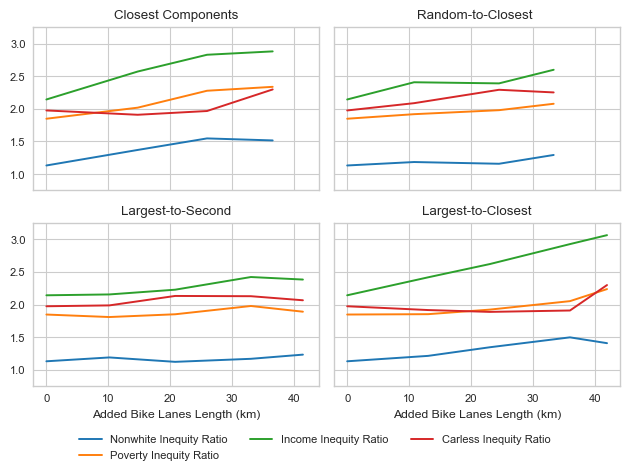

In [94]:
files = ["cc", "r2c", "l22", "l2c"]
plt.style.use("seaborn-v0_8-paper")
fig, axs = plt.subplots(2, 2, sharey=True, sharex=True)

for i, file in enumerate(files):
    data = pd.read_csv("data/" + file + ".csv")

    data["nonwhite_ratio"] = data["nonwhite_low"] / data["nonwhite_high"]

    data["poverty_ratio"] = data["poverty_low"] / data["poverty_high"]

    data["income_ratio"] = data["income_high"] / data["income_low"]

    data["carless_ratio"] = data["carless_low"] / data["carless_high"]

    data["length_added_bikelanes"] /= 1000

    data = data[
        [
            "length_added_bikelanes",
            "number_cc",
            "overall_score",
            "nonwhite_ratio",
            "poverty_ratio",
            "income_ratio",
            "carless_ratio",
        ]
    ]

    data = data.rename(
        columns={
            "length_added_bikelanes": "Added Bike Lanes Length (km)",
            "overall_score": "Overall Bikeability",
            "nonwhite_ratio": "Nonwhite Inequity Ratio",
            "poverty_ratio": "Poverty Inequity Ratio",
            "income_ratio": "Income Inequity Ratio",
            "carless_ratio": "Carless Inequity Ratio",
        }
    )

    plt.style.use("seaborn-v0_8-whitegrid")

    if file == "l2c":
        file = "Largest-to-Closest"
    elif file == "l22":
        file = "Largest-to-Second"
    elif file == "cc":
        file = "Closest Components"

    else:
        file = "Random-to-Closest "

    data.drop(["number_cc", "Overall Bikeability"], axis=1).plot(
        ax=axs[i // 2][i % 2],
        x="Added Bike Lanes Length (km)",
        title=file,
        sharey=True,
        sharex=True,
        legend=False,
        ylim=(0.75, 3.25),
    )
    if file == "Largest-to-Closest":

        handles, labels = axs[0][0].get_legend_handles_labels()

        unique_labels = [
            "Nonwhite Inequity Ratio",
            "Poverty Inequity Ratio",
            "Income Inequity Ratio",
            "Carless Inequity Ratio",
        ]

        unique_handles = [
            handle for handle, label in zip(handles, labels) if label in unique_labels
        ]

        fig.legend(
            handles=unique_handles,
            labels=unique_labels,
            loc="center",
            bbox_to_anchor=(0.5, -0.03),
            ncol=3,
            edgecolor="black",
        )

plt.tight_layout()
plt.savefig("figures/old_alg_inequity_metrics")

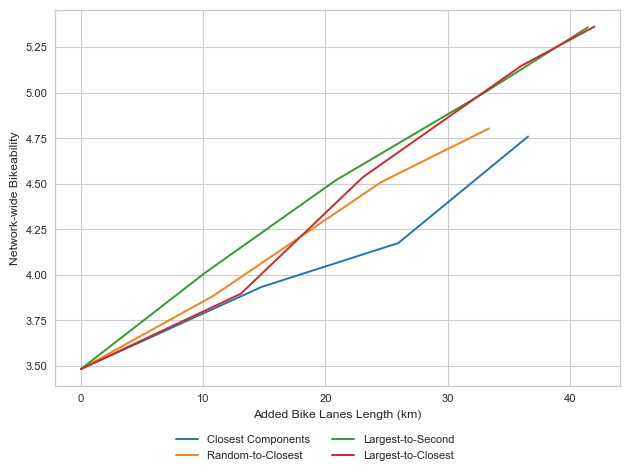

In [38]:
plt.style.use("seaborn-v0_8-paper")
fig, ax = plt.subplots()

for i, file in enumerate(files):
    data = pd.read_csv("data/" + file + ".csv")

    if file == "l2c":
        file = "Largest-to-Closest"
    elif file == "l22":
        file = "Largest-to-Second"
    elif file == "cc":
        file = "Closest Components"
    else:
        file = "Random-to-Closest "

    data["length_added_bikelanes"] /= 1000

    ax.plot(data["length_added_bikelanes"], data["overall_score"], label=file)

fig.legend(loc="center", bbox_to_anchor=(0.5, -0.03), ncol=2)
ax.set_xlabel("Added Bike Lanes Length (km)")
ax.set_ylabel("Network-wide Bikeability")
plt.tight_layout()
plt.savefig("figures/old_alg_overall_metrics")

In [66]:
files = ["l2c", "l22", "r2c", "cc",]

for file in files:
    print(file)
    data = pd.read_csv("data/" + file + ".csv")

    data["nonwhite_ratio"] = data["nonwhite_low"] / data["nonwhite_high"]
    data["poverty_ratio"] = data["poverty_low"] / data["poverty_high"]
    data["income_ratio"] = data["income_high"] / data["income_low"]
    data["carless_ratio"] = data["carless_low"] / data["carless_high"]
    data["length_added_bikelanes"] /= 1000

    # data = data[
    #     [
    #         "length_added_bikelanes",
    #         "number_cc",
    #         "overall_score",
    #         "nonwhite_ratio",
    #         "poverty_ratio",
    #         "income_ratio",
    #         "carless_ratio",
    #     ]
    # ]

    data = data.reindex(sorted(data.columns), axis=1)
    
    print(((data.iloc[-1] - data.iloc[0])/ data.iloc[0] * 100)[["carless_ratio", "income_ratio",
                                                                "nonwhite_ratio",
                                                                "poverty_ratio",
                                                                "overall_score"]])

l2c
carless_ratio     16.465106
income_ratio      43.023753
nonwhite_ratio    24.550565
poverty_ratio     21.115615
overall_score     53.990633
dtype: float64
l22
carless_ratio      4.651687
income_ratio      11.261916
nonwhite_ratio     9.025175
poverty_ratio      2.357499
overall_score     53.884237
dtype: float64
r2c
carless_ratio     13.998474
income_ratio      21.251384
nonwhite_ratio    14.239076
poverty_ratio     12.405214
overall_score     37.930903
dtype: float64
cc
carless_ratio     16.310245
income_ratio      34.409150
nonwhite_ratio    33.945627
poverty_ratio     26.460236
overall_score     36.666434
dtype: float64


In [ ]:
# old algs map plot
algs = [large_to_close, large_to_second, random_to_close, closest_components]
new_graphs = []

for alg in algs: new_graphs.append(gen_new_graph(alg))  

Matched: San Francisco,CA to San Francisco city within layer Incorporated Places


c:\Users\ckaz3\Documents\Academics\College\equitable-cycling-networks\dem_functions.py:8: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  dem = acs.from_place(place,level='tract',place_type='Incorporated Place',variables=list(acs_vars.keys()))


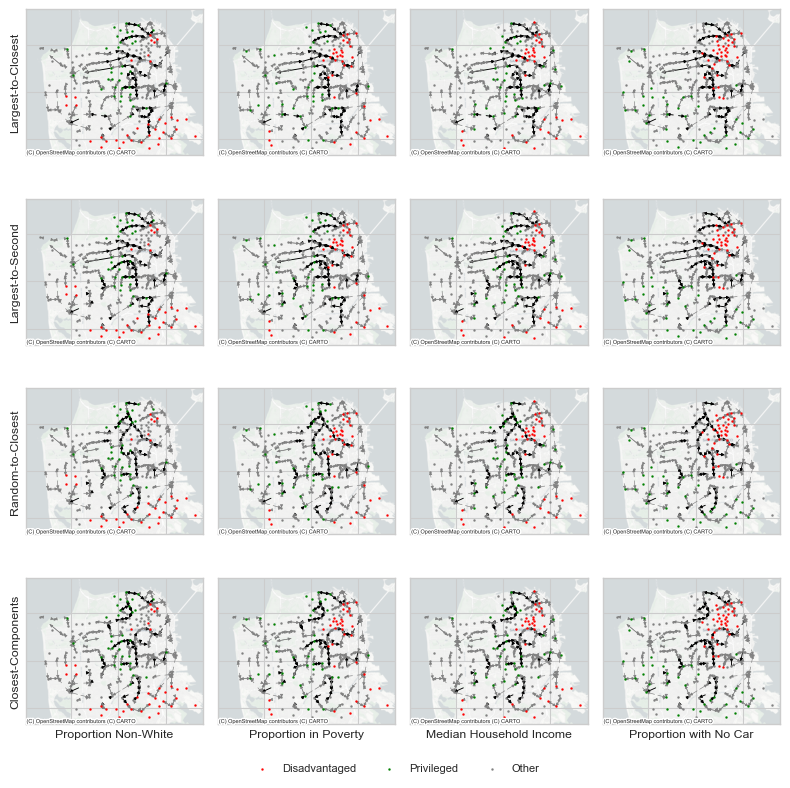

In [95]:
G_SF, dem_SF = yhf.load_sf_data()

# graph of all bikelanes
G_bikelanes = nx.DiGraph()

# create bikelane and potential bikelane networks
for start_node, end_node, data in G_SF.edges(data=True):
    if not np.isnan(data["distance"][0]):
        G_bikelanes.add_edge(start_node, end_node, distance=data["distance"][0])

algs = ["large_to_close", "large_to_second", "random_to_close", "closest_components"]

keys = ["frac_pop_nonwhite", "frac_below_poverty", "median_hh_income", "frac_no_car"]

plt.style.use("seaborn-v0_8-whitegrid")

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(8, 8), sharex=True, sharey=True)

for j, key in enumerate(keys):

    if key in ["median_hh_income"]:
        dis_nodes, priv_nodes = df.all_quants([key], dem_SF)[key]

    else:
        priv_nodes, dis_nodes = df.all_quants([key], dem_SF)[key]

    other_nodes = []

    for node in G_SF.nodes:
        if node not in dis_nodes and node not in priv_nodes:
            other_nodes.append(node)

    coords = [nx.get_node_attributes(G_SF, "x"), nx.get_node_attributes(G_SF, "y")]
    node_pos = {}

    for k in coords[0].keys():
        node_pos[k] = tuple(d[k] for d in coords)

    for i, G in enumerate(new_graphs):
        nx.draw_networkx_edges(
            G,
            pos=node_pos,
            arrowsize=4.4,
            width=0.66,
            ax=axs[i][j],
            label="New Bike Lanes",
        )
        nx.draw_networkx_edges(
            G_bikelanes,
            edge_color="gray",
            pos=node_pos,
            arrowsize=4.4,
            width=0.44,
            ax=axs[i][j],
            label="Existing Bike Lanes",
        )
        nx.draw_networkx_nodes(
            G,
            pos=node_pos,
            ax=axs[i][j],
            nodelist=dis_nodes,
            node_color="red",
            node_size=2,
            label="Privileged",
        )
        nx.draw_networkx_nodes(
            G,
            pos=node_pos,
            ax=axs[i][j],
            nodelist=priv_nodes,
            node_color="green",
            node_size=2,
            label="Disadvantaged",
        )
        nx.draw_networkx_nodes(
            G,
            pos=node_pos,
            ax=axs[i][j],
            nodelist=other_nodes,
            node_color="gray",
            node_size=2,
            label="Other",
        )
        cx.add_basemap(
            ax=axs[i][j], source=cx.providers.CartoDB.Positron, attribution_size=4
        )

algs = [
    "Largest-to-Closest",
    "Largest-to-Second",
    "Random-to-Closest",
    "Closest-Components",
]

keys = [
    "Proportion Non-White",
    "Proportion in Poverty",
    "Median Household Income",
    "Proportion with No Car",
]

for i, key in enumerate(keys):

    axs[3][i].set_xlabel(key)

for i, alg in enumerate(algs):

    axs[i][0].set_ylabel(alg)

handles, labels = axs[0][0].get_legend_handles_labels()

unique_labels = [
    "Disadvantaged",
    "Privileged",
    "Other",
    "Existing Bike Lanes",
    "New Bike Lanes",
]

unique_handles = [
    handle for handle, label in zip(handles, labels) if label in unique_labels
]

fig.legend(
    handles=unique_handles,
    labels=unique_labels,
    loc="center",
    bbox_to_anchor=(0.5, 0),
    ncol=3,
)

plt.tight_layout()
plt.savefig("figures/old_alg_maps")

In [29]:
axs.get_legend_handles_labels()

AttributeError: 'numpy.ndarray' object has no attribute 'get_legend_handles_labels'